# Created by hcy 20200722 22:11
### BackGround: 使用CNN进行信用卡欺诈检测

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv1D, MaxPool1D
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

E:\Anaconda5.2\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
data = pd.read_csv('./creditcard.csv')
print(data.shape)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
type(data.isnull().sum())

pandas.core.series.Series

In [13]:
pd.DataFrame(data.isnull().sum().reset_index())

,index,0
0,Time,0
1,V1,0
2,V2,0
3,V3,0
4,V4,0
5,V5,0
6,V6,0
7,V7,0
8,V8,0
9,V9,0


In [34]:
def missing_values_percent(df):
    aa = pd.DataFrame(df.isnull().sum().reset_index().rename(columns={'index': 'feature', 0: 'cnt'}))
    aa['values_percent'] = aa['cnt'] / df.shape[0]
    aa = aa[aa['values_percent'] > 0]
    if aa.shape[0] > 0:
        aa = aa.sort_values(by=['values_percent'], ascending=False)
        return aa
    else:
        return aa

In [35]:
missing_values_percent(data)

,feature,cnt,values_percent


## 缺失值为0

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [37]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [38]:
284315 / 492

577.8760162601626

## 数据集及不平衡

## Balance DataSet

In [39]:
non_fraud = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]
print(non_fraud.shape, fraud.shape)

(284315, 31) (492, 31)


In [40]:
pd.DataFrame.sample??

In [43]:
non_fraud = non_fraud.sample(fraud.shape[0])
non_fraud.shape

(492, 31)

In [44]:
data = fraud.append(non_fraud, ignore_index=True)
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,55996.0,1.179447,0.358758,0.978514,1.357137,-0.738976,-1.030758,-0.024007,-0.180062,0.007455,0.013188,0.191420,0.709449,0.580660,0.132667,0.991602,0.181093,-0.391009,-0.344571,-0.673872,-0.119662,-0.037905,-0.060652,0.094090,0.904090,0.362072,-0.513161,0.039119,0.037821,2.00,0
980,147207.0,-0.617977,1.121090,0.141068,-1.128888,1.745238,-1.591692,2.284964,-0.735824,-0.808635,-0.871520,-0.968657,-0.466457,-0.751859,0.613898,-0.601621,-0.984966,-0.360582,-0.489960,-0.488037,-0.130544,0.243325,0.909248,-0.912468,-0.014055,1.657699,0.141233,-0.232466,-0.212889,1.00,0
981,66100.0,-3.061628,2.344753,-1.203676,-1.409890,-1.569914,-0.511128,-1.448280,2.381423,0.279852,-0.555596,-1.845727,-0.027695,-0.819181,1.449767,0.849287,1.207716,0.157074,-0.271611,-0.940039,-0.145699,-0.071986,-0.564691,0.136491,-0.770447,0.047302,0.837283,0.017436,-0.064825,19.99,0
982,55481.0,0.885458,-0.218163,0.011650,1.256135,0.065318,0.420471,0.149893,0.208574,-0.092570,0.048003,1.360675,0.707178,-1.124965,0.707008,-0.093017,-0.714491,0.254960,-0.717197,-0.595517,-0.042342,0.132621,0.272123,-0.190585,-0.289438,0.588776,-0.228132,0.010967,0.014996,119.06,0


In [45]:
data.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

In [46]:
X = data.drop(['Class'], axis=1)
y = data['Class']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(X_train.shape, X_test.shape)

(787, 30) (197, 30)


In [48]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [50]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## BUILD CNN

In [67]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [68]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_v2_8 (Ba (None, 29, 32)            128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 29, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_v2_9 (Ba (None, 28, 64)            256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792)             

In [69]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

Train on 787 samples, validate on 197 samples
Epoch 1/20
787/787 [==============================] - 3s 4ms/sample - loss: 0.7647 - accuracy: 0.7027 - val_loss: 0.6189 - val_accuracy: 0.8680
Epoch 2/20
787/787 [==============================] - 0s 200us/sample - loss: 0.4579 - accuracy: 0.8196 - val_loss: 0.5715 - val_accuracy: 0.8934
Epoch 3/20
787/787 [==============================] - 0s 198us/sample - loss: 0.3916 - accuracy: 0.8526 - val_loss: 0.5352 - val_accuracy: 0.8883
Epoch 4/20
787/787 [==============================] - 0s 193us/sample - loss: 0.3925 - accuracy: 0.8679 - val_loss: 0.4964 - val_accuracy: 0.9137
Epoch 5/20
787/787 [==============================] - 0s 196us/sample - loss: 0.3490 - accuracy: 0.8755 - val_loss: 0.4727 - val_accuracy: 0.8883
Epoch 6/20
787/787 [==============================] - 0s 202us/sample - loss: 0.2662 - accuracy: 0.9022 - val_loss: 0.4501 - val_accuracy: 0.8579
Epoch 7/20
787/787 [==============================] - 0s 197us/sample - loss: 0.

In [71]:
def plot_learningCureve(history):
    epoch_range = range(1, 21)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

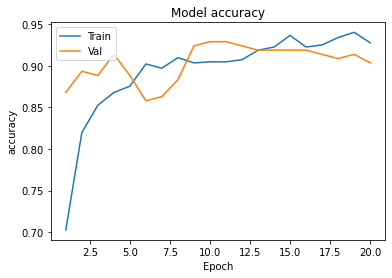

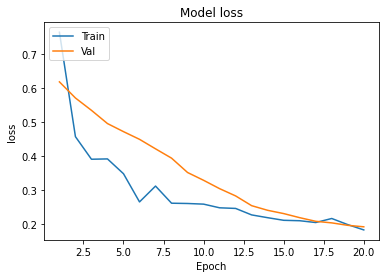

In [72]:
plot_learningCureve(history)

In [74]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c9e0038a58>)

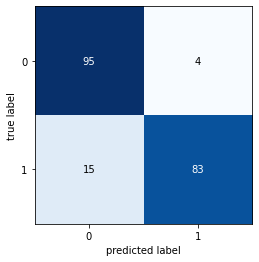

In [78]:
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_true=y_test, y_pred=y_pred)

plot_confusion_matrix(conf_mat=mat)

In [79]:
from sklearn.metrics import recall_score

recall_score(y_pred=y_pred, y_true=y_test, pos_label=1)

0.8469387755102041

In [80]:
83 / (83+15)

0.8469387755102041

In [81]:
print(non_fraud.shape)

(492, 31)


In [83]:
data_all_predict = data.drop(columns=['Class'],axis=1)
data_all_predict = scaler.transform(data_all_predict)
print(data_all_predict.shape)
data_all_predict[0]

array([-1.80927404,  0.03422702,  0.00822127,  0.32087402,  0.49576932,
        0.24996258, -0.37763326,  0.06155413,  0.23140456, -0.62429584,
        0.02695502,  0.45824157,  0.06033456, -0.52045433, -0.16686338,
        0.43609244,  0.27205585,  0.08856344,  0.46787011,  0.07157374,
       -0.08819732,  0.07412203, -0.05694665, -0.40715064,  0.64329342,
        0.02700634,  0.28347098,  0.15921278, -0.3821715 , -0.4737292 ])

In [85]:
data_all_predict = data_all_predict.reshape(data_all_predict.shape[0], data_all_predict.shape[1], 1)

In [86]:
y_pred_all = model.predict_classes(data_all_predict)
y_true_all = data['Class'].to_numpy()

0.9126016260162602
0.9420731707317073


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c9e1a754e0>)

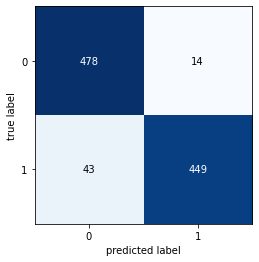

In [87]:
## 坏帐本召回率
print(recall_score(y_pred=y_pred_all, y_true=y_true_all, pos_label=1))
## 整体的正确率
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred=y_pred_all, y_true=y_true_all))

## 混淆矩阵
mat_all = confusion_matrix(y_pred=y_pred_all, y_true=y_true_all)

plot_confusion_matrix(mat_all)

In [93]:
from sklearn.metrics import auc, roc_curve

In [94]:
fpr, tpr, thresholds = roc_curve(y_true_all, y_pred_all, pos_label=1)
auc(fpr, tpr)

0.9420731707317074

In [95]:
confusion_matrix??